---
title: Precision and Recall
jupyter: "precision_recall"
description: "Significance of precision and recall"
author: "Shataxi Dubey"
date: "2024-05-23"
categories: [metrics]
format:
    html:
        toc: true
---

When a model has high recall but low precision, then the model classifies most of the positive samples correctly but it has many false positives (i.e. classifies many Negative samples as Positive). When a model has high precision but low recall, then the model is accurate when it classifies a sample as Positive but it may classify only some of the positive samples.

Note that as the recall increases, the precision decreases. The reason is that when the number of positive samples increases (high recall), the accuracy of classifying each sample correctly decreases (low precision). This is expected, as the model is more likely to fail when there are many samples.

In [9]:
import numpy as np

y_true = ["positive", "negative", "negative", "positive", "positive", "positive", "negative", "positive", "negative", "positive", "positive", "positive", "positive", "negative", "negative", "negative"]

pred_scores = [0.7, 0.3, 0.5, 0.6, 0.55, 0.9, 0.4, 0.2, 0.4, 0.3, 0.7, 0.5, 0.8, 0.2, 0.3, 0.35]

thresholds = np.arange(start=0.2, stop=0.7, step=0.05)

In [10]:
import sklearn.metrics

def precision_recall_curve(y_true, pred_scores, thresholds):
    precisions = []
    recalls = []
    
    for threshold in thresholds:
        y_pred = ["positive" if score >= threshold else "negative" for score in pred_scores]

        precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
        
        precisions.append(precision)
        recalls.append(recall)

    return precisions, recalls

In [11]:
# when threshold(0.2) is low, all predicted samples become positive and it will definetly include actual positives 
# so recall will be high but precision will be low because total predicted positives are more than actual positives
y_pred = ["positive" if score >= 0.2 else "negative" for score in pred_scores]
precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
print(f'Precision {precision}, Recall {recall}')

Precision 0.5625, Recall 1.0


In [12]:
# when threshold(0.9) is high, positive samples will be actual positive samples so they become true positive which makes precision high
# that is the model is more than 0.9 sure that the sample is positive, so it will be an actual positive but still you are not covering all 
# positives because of keeping high threshold
y_pred = ["positive" if score >= 0.9 else "negative" for score in pred_scores]
precision = sklearn.metrics.precision_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
recall = sklearn.metrics.recall_score(y_true=y_true, y_pred=y_pred, pos_label="positive")
print(f'Precision {precision}, Recall {recall}')

Precision 1.0, Recall 0.1111111111111111


In [13]:
precisions, recalls = precision_recall_curve(y_true, pred_scores, thresholds)
print(f'Precision list {precisions}')
print(f'Recall list {recalls}')

Precision list [0.5625, 0.5714285714285714, 0.5714285714285714, 0.6363636363636364, 0.7, 0.875, 0.875, 1.0, 1.0, 1.0]
Recall list [1.0, 0.8888888888888888, 0.8888888888888888, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.6666666666666666, 0.5555555555555556, 0.4444444444444444]


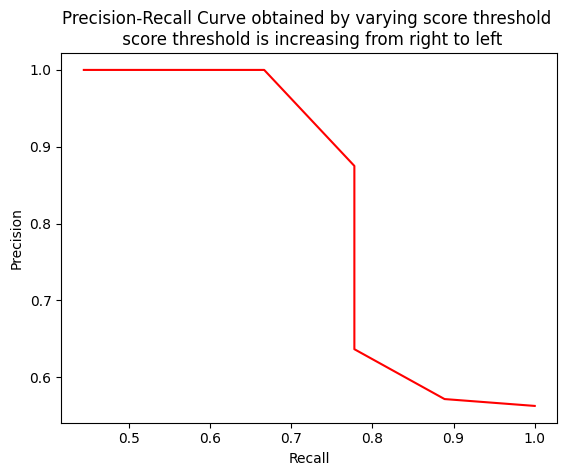

In [14]:
import matplotlib.pyplot as plt
plt.plot(recalls, precisions, color="red")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve obtained by varying score threshold \n score threshold is increasing from right to left")
plt.show()


Similarly, if we vary IOU threshold then we will get another precision recall curve

In [57]:
def compute_ap(recall, precision):
    #from ultralytics
    # Append sentinel values to beginning and end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([1.0], precision, [0.0]))
    print(f'mpre {mpre}')
    print(f'np.flip {np.flip(mpre)}')
    print(f'np.accumulate.maximum {np.maximum.accumulate(np.flip(mpre))}')
    # Compute the precision envelope
    mpre = np.flip(np.maximum.accumulate(np.flip(mpre)))

    # Integrate area under curve
    method = "interp"  # methods: 'continuous', 'interp'
    if method == "interp":
        x = np.linspace(0, 1, 101)  # 101-point interp (COCO)
        ap = np.trapz(np.interp(x, mrec, mpre), x)  # integrate
    else:  # 'continuous'
        i = np.where(mrec[1:] != mrec[:-1])[0]  # points where x-axis (recall) changes
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])  # area under curve

    return ap, mpre, mrec

In [58]:
def smooth(y, f=0.05):
    """Box filter of fraction f."""
    nf = round(len(y) * f * 2) // 2 + 1  # number of filter elements (must be odd)
    p = np.ones(nf // 2)  # ones padding
    yp = np.concatenate((p * y[0], y, p * y[-1]), 0)  # y padded
    return np.convolve(yp, np.ones(nf) / nf, mode="valid")  # y-smoothed

In [64]:
def ap_per_class(
    tp, conf, pred_cls, target_cls, plot=False,eps=1e-16):
    
    # Sort by objectness
    i = np.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i] # decreasing order of  confidences
    tp = tp.reshape((tp.shape[0],1))
    # Find unique classes
    unique_classes, nt = np.unique(target_cls, return_counts=True)
    nc = unique_classes.shape[0]  # number of classes, number of detections

    # Create Precision-Recall curve and compute AP for each class
    x, prec_values = np.linspace(0, 1, 1000), []

    # Average precision, precision and recall curves
    ap, p_curve, r_curve = np.zeros((nc, tp.shape[1])), np.zeros((nc, 1000)), np.zeros((nc, 1000))
    for ci, c in enumerate(unique_classes):
        i = pred_cls == c
        n_l = nt[ci]  # number of labels or ground truth
        n_p = i.sum()  # number of predictions
        if n_p == 0 or n_l == 0:
            continue

        # Accumulate FPs and TPs
        fpc = (1 - tp[i]).cumsum(0) 
        tpc = tp[i].cumsum(0)
        
        # Recall
        recall = tpc / (n_l + eps)  # recall curve
        print(f'recall {recall[:,0]}')
        # print(f'-conf[i] {-conf[i]}')
        r_curve[ci] = np.interp(-x, -conf[i], recall[:, 0], left=0)  # negative x, xp because xp decreases
        # print(f'r_curve[ci] {r_curve[ci]}')
        # Precision
        precision = tpc / (tpc + fpc)  # precision curve
        print(f'precision {precision[:,0]}')
        # print(f'-conf[i] {-conf[i]}')
        p_curve[ci] = np.interp(-x, -conf[i], precision[:, 0], left=1)  # p at pr_score
        # print(f'p_curve[ci] {p_curve[ci]}')
        # AP from recall-precision curve
        for j in range(tp.shape[1]):
            ap[ci, j], mpre, mrec = compute_ap(recall[:, j], precision[:, j])
            print(f'AP {ap[ci,j]}')
            if plot and j == 0:
                prec_values.append(np.interp(x, mrec, mpre))  

    prec_values = np.array(prec_values)  # (nc, 1000)

    # Compute F1 (harmonic mean of precision and recall)
    f1_curve = 2 * p_curve * r_curve / (p_curve + r_curve + eps)

    i = smooth(f1_curve.mean(0), 0.1).argmax()  # max F1 index
    p, r, f1 = p_curve[:, i], r_curve[:, i], f1_curve[:, i]  # max-F1 precision, recall, F1 values
    tp = (r * nt).round()  # true positives
    fp = (tp / (p + eps) - tp).round()  # false positives
    # return tp, fp, p, r, ap, f1, unique_classes.astype(int), p_curve, r_curve, f1_curve, x, prec_values
    return 1

True positives are decided using IOU


class 1
p = 1, r = 0.33
p = 0.5, r = 0.33
p = 0.66, r = 0.66

class 2
p = 1, r = 0.5
p = 0.5, r = 0.5

In [65]:
tp = np.array([1,0,1,1,0])
conf = np.array([1,1,1,1,1])
pred_cls = np.array(['1','1','1','2','2'])
target_cls = np.array(['1','1','1','2','2'])
ap_per_class(tp, conf, pred_cls, target_cls, plot=False,eps=1e-16)

recall [0.33333333 0.33333333 0.66666667]
precision [1.         0.5        0.66666667]
mpre [1.         1.         0.5        0.66666667 0.        ]
np.flip [0.         0.66666667 0.5        1.         1.        ]
np.accumulate.maximum [0.         0.66666667 0.66666667 1.         1.        ]
AP 0.6672
recall [0.5 0.5]
precision [1.  0.5]
mpre [1.  1.  0.5 0. ]
np.flip [0.  0.5 1.  1. ]
np.accumulate.maximum [0.  0.5 1.  1. ]
AP 0.6224999999999999


1